In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import (mean_absolute_error, mean_squared_error)

In [16]:
# read in the dataset
df = pd.read_csv("data_for_modeling.csv")
df.head()

,role,seniority,avg_salary,state,company_rating,company_size,sector,company_age,city,region
0,data scientist,2,72.0,NM,3.8,2.0,Aerospace & Defense,47.0,other,West
1,data scientist,2,87.5,MD,3.4,3.0,Health Care,36.0,other,South
2,data scientist,2,85.0,FL,4.8,2.0,Business Services,10.0,other,South
3,data scientist,2,76.5,WA,3.8,3.0,"Oil, Gas, Energy & Utilities",55.0,Richland,West
4,data scientist,2,114.5,NY,2.9,1.0,Business Services,22.0,New York,Northeast


In [17]:
# drop city and state from the dataset as these will create a sparse matrix if used as dummy variables (too many dimensions)
df = df.drop(['city', 'state'], axis =1)

In [18]:
# get dummy variables for all of the categorical variables in the dataframe (role, sector, region)
df_modeling = pd.get_dummies(df)

In [19]:
# look at the details of the new data created
df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   seniority                            742 non-null    int64  
 1   avg_salary                           742 non-null    float64
 2   company_rating                       742 non-null    float64
 3   company_size                         742 non-null    float64
 4   company_age                          742 non-null    float64
 5   role_data analyst                    742 non-null    uint8  
 6   role_data engineer                   742 non-null    uint8  
 7   role_data scientist                  742 non-null    uint8  
 8   role_director                        742 non-null    uint8  
 9   role_machine learning engineer       742 non-null    uint8  
 10  role_manager                         742 non-null    uint8  
 11  role_other                      

In [20]:
df['company_size'].value_counts()

3.0    366
2.0    251
1.0    125
Name: company_size, dtype: int64

In [21]:
# look at the range of values for each column to ensure there are no strange values
df_modeling.describe()

,seniority,avg_salary,company_rating,company_size,company_age,role_data analyst,role_data engineer,role_data scientist,role_director,role_machine learning engineer,...,sector_Information Technology,sector_Insurance,sector_Manufacturing,"sector_Oil, Gas, Energy & Utilities",sector_Retail,sector_other,region_Midwest,region_Northeast,region_South,region_West
count,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,...,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000
mean,2.051213,101.484501,3.688372,2.324798,50.030347,0.192722,0.160377,0.376011,0.017520,0.020216,...,0.242588,0.092992,0.045822,0.018868,0.020216,0.095687,0.138814,0.311321,0.264151,0.285714
std,0.340782,37.482449,0.566104,0.746312,52.233003,0.394703,0.367203,0.484710,0.131288,0.140832,...,0.428937,0.290617,0.209240,0.136150,0.140832,0.294360,0.345986,0.463346,0.441177,0.452059
min,1.000000,15.500000,1.900000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,73.500000,3.300000,2.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,97.500000,3.700000,2.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,122.500000,4.000000,3.000000,59.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,3.000000,254.000000,5.000000,3.000000,276.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Scaling Data and Splitting

In [22]:
# predictor vars
X = df_modeling.loc[:, df_modeling.columns != 'avg_salary']
# response variable
y = df_modeling['avg_salary']

# create the train test split with 80% of the data in the training set (dataset isn't very large)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

# initialize the standard scaler object
# this standardizes the features to mean = 0, and standard deviation = 1
scaler = StandardScaler()
# created a scaled version of the X_train set by fitting and transforming the scaler to this dataset
X_train_scaled = scaler.fit_transform(X_train)
# use the standard scaler fit on the training data to scale the test set so there is no data leakage
X_test_scaled = scaler.transform(X_test)

## Linear Regression

Lets start the modeling with a very simple linear regression model to predict average salary. We will then work up to regularized regression using Lasso and Ridge Regression.

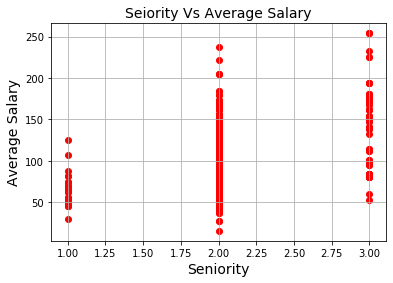

In [23]:
plt.scatter(df['seniority'], df['avg_salary'], color='red')
plt.title('Seiority Vs Average Salary', fontsize=14)
plt.xlabel('Seniority', fontsize=14)
plt.ylabel('Average Salary', fontsize=14)
plt.grid(True)
plt.show()

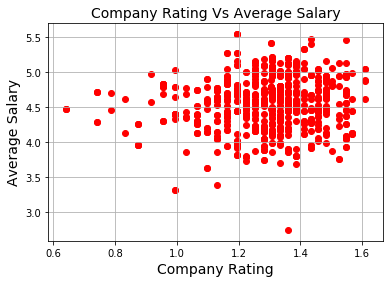

In [36]:
# the log transform of company_rating and avg_salary gives the most linear and tight fit
plt.scatter(df['company_rating'].apply(np.log), df['avg_salary'].apply(np.log), color='red')
plt.title('Log Company Rating Vs Log Average Salary', fontsize=14)
plt.xlabel('ln(Company Rating)', fontsize=14)
plt.ylabel('ln(Average Salary)', fontsize=14)
plt.grid(True)
plt.show()

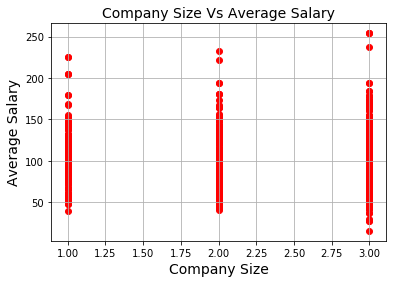

In [41]:
plt.scatter(df['company_size'], df['avg_salary'], color='red')
plt.title('Company Size Vs Average Salary', fontsize=14)
plt.xlabel('Company Size', fontsize=14)
plt.ylabel('Average Salary', fontsize=14)
plt.grid(True)
plt.show()

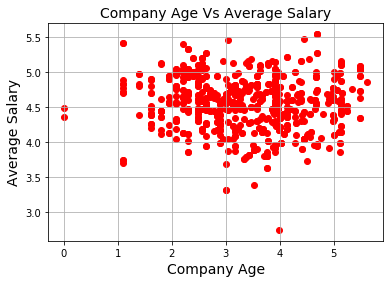

In [38]:
# the log transform of company_rating and avg_salary gives the most linear and tight fit
plt.scatter(df['company_age'].apply(np.log), df['avg_salary'].apply(np.log), color='red')
plt.title('Log Company Age Vs Log Average Salary', fontsize=14)
plt.xlabel('ln(Company Age)', fontsize=14)
plt.ylabel('ln(Average Salary)', fontsize=14)
plt.grid(True)
plt.show()

In [44]:
X_reg = sm.add_constant(X_train)
X_reg[['company_rating','company_age']] = X_reg[['company_rating','company_age']].apply(np.log)
lin_reg = sm.OLS(y_train.apply(np.log), X_reg).fit()
lin_reg.summary()

# variables that are important ()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg_salary   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     15.49
Date:                Thu, 28 May 2020   Prob (F-statistic):           4.67e-53
Time:                        23:05:50   Log-Likelihood:                -94.691
No. Observations:                 593   AIC:                             247.4
Df Residuals:                     564   BIC:                             374.6
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   2.6372      0.109     24.150      0.000       2.423       2.852
seniority                               0.2585      0.041      6.319      0.000       0.178       0.339
company_rating                          0.1121      0.086      1.301      0.194      -0.057       0.281
company_size                            0.0163      0.020      0.831      0.406      -0.022       0.055
company_age                            -0.0021      0.014     -0.150      0.881      -0.030       0.025
role_data analyst                       0.0123      0.039      0.314      0.754      -0.065       0.089
role_data engineer                      0.3654      0.042      8.799      0.000       0.284       0.447
role_data scientist                     0.4795      0.036     13.205      0.000       0.408       0.551
role_director                           0.4901      0.107      4.598      0.000       0.281       0.699
role_machine learning engineer          0.4275      0.091      4.705      0.000       0.249       0.606
role_manager                            0.0998      0.071      1.400      0.162      -0.040       0.240
role_other                              0.1675      0.043      3.895      0.000       0.083       0.252
role_product analyst                   -0.0420      0.191     -0.220      0.826      -0.417       0.333
role_research scientist                 0.3205      0.078      4.095      0.000       0.167       0.474
role_software engineer                  0.3166      0.138      2.290      0.022       0.045       0.588
sector_Aerospace & Defense              0.2080      0.067      3.092      0.002       0.076       0.340
sector_Biotech & Pharmaceuticals        0.3636      0.038      9.692      0.000       0.290       0.437
sector_Business Services                0.1867      0.038      4.866      0.000       0.111       0.262
sector_Education                        0.2909      0.071      4.110      0.000       0.152       0.430
sector_Finance                          0.1827      0.049      3.766      0.000       0.087       0.278
sector_Government                       0.2067      0.099      2.084      0.038       0.012       0.402
sector_Health Care                      0.0325      0.049      0.664      0.507      -0.064       0.129
sector_Information Technology           0.2949      0.034      8.548      0.000       0.227       0.363
sector_Insurance                        0.2282      0.044      5.177      0.000       0.142       0.315
sector_Manufacturing                    0.3324      0.057      5.803      0.000       0.220       0.445
sector_Oil, Gas, Energy & Utilities    -0.1216      0.088     -1.381      0.168      -0.295       0.051
sector_Retail                           0.2575      0.082      3.15

In [46]:
X_reg = sm.add_constant(X_train[['seniority', 'role_data analyst',
              'role_data scientist', 'role_director',
               'sector_Biotech & Pharmaceuticals',
              'sector_Health Care', 'sector_Information Technology',
              'sector_Oil, Gas, Energy & Utilities', 'region_West']])
# regressing the log of average salary on the subset of the predictors from the full model that are significant
lin_reg2 = sm.OLS(y_train.apply(np.log), X_reg).fit()
lin_reg2.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg_salary   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     40.83
Date:                Thu, 28 May 2020   Prob (F-statistic):           1.84e-56
Time:                        23:08:14   Log-Likelihood:                -2835.7
No. Observations:                 593   AIC:                             5691.
Df Residuals:                     583   BIC:                             5735.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  36.1369      8.348      4.329      0.000      19.740      52.534
seniority                              26.2032      4.018      6.522      0.000      18.312      34.094
role_data analyst                     -19.4690      3.334     -5.840      0.000     -26.016     -12.922
role_data scientist                    21.0325      2.814      7.474      0.000      15.505      26.560
role_director                          43.7154     10.720      4.078      0.000      22.661      64.770
sector_Biotech & Pharmaceuticals       12.3435      3.655      3.377      0.001       5.165      19.522
sector_Health Care                    -20.0949      5.011     -4.011      0.000     -29.936     -10.254
sector_Information Technology          10.6790      3.033      3.521      0.000       4.721      16.637
sector_Oil, Gas, Energy & Utilities   -35.2459      9.216     -3.825      0.000     -53.346     -17.146
region_West                            14.4873      2.783      5.205      0.000       9.021      19.954
==============================================================================
Omnibus:                       63.566   Durbin-Watson:                   2.106
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.883
Skew:                           0.638   Prob(JB):                     4.62e-28
Kurtosis:                       4.861   Cond. No.                         23.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
train_pred = lin_reg2.predict(X_reg)

In [50]:
RMSE_lin_reg = mean_squared_error(y_train, train_pred, squared = False)
print(RMSE_lin_reg)

28.8783500918813


In [51]:
MAE_lin_reg = mean_absolute_error(y_train, train_pred)
print(MAE_lin_reg)

22.29943214811279


In [53]:
pred = lin_reg2.predict(sm.add_constant(X_test[['seniority', 'role_data analyst',
              'role_data scientist', 'role_director',
               'sector_Biotech & Pharmaceuticals',
              'sector_Health Care', 'sector_Information Technology',
              'sector_Oil, Gas, Energy & Utilities', 'region_West']]))

RMSE_lin_reg = mean_squared_error(y_test, pred, squared = False)
print(RMSE_lin_reg)

MAE_lin_reg = mean_absolute_error(y_test, pred)
print(MAE_lin_reg)

# these estimates are around $23,000 off on average

28.480281353128383
23.148276887054603
